### Henry Carpenter - Final Project, Part 3, Scratch:

### Loading the data

In [1]:
#  Loading in the relevant packages

import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline

In [3]:
#  Loading in the files that weren't too large to remain single files
listings_df = pd.read_csv('./listings.csv')
neighbourhoods_df = pd.read_csv('./neighbourhoods.csv')
reviews_df = pd.read_csv('./reviews.csv')

In [4]:
#  Loading in the files that had to be split into several pieces
listings_1_df = pd.read_csv('./listings_1.csv')
listings_2_df = pd.read_csv('./listings_2.csv')
listings_3_df = pd.read_csv('./listings_3.csv')
listings_4_df = pd.read_csv('./listings_4.csv')

In [5]:
#  Loading in the files that had to be split into several pieces
calendar1_df = pd.read_csv('./calendar1.csv')
calendar2_df = pd.read_csv('./calendar2.csv')
calendar3_df = pd.read_csv('./calendar3.csv')
calendar4_df = pd.read_csv('./calendar4.csv')

In [6]:
#  Loading in the files that had to be split into several pieces
reviews_1_df = pd.read_csv('./reviews_1.csv')
reviews_2_df = pd.read_csv('./reviews_2.csv')
reviews_3_df = pd.read_csv('./reviews_3.csv')
reviews_4_df = pd.read_csv('./reviews_4.csv')
reviews_5_df = pd.read_csv('./reviews_5.csv')
reviews_6_df = pd.read_csv('./reviews_6.csv')

In [7]:
#  Appending the several smaller files to recreate the inital larger file
reviews_summary_df = reviews_1_df.append(reviews_2_df.append(reviews_3_df.append(reviews_4_df.append(reviews_5_df.append(reviews_6_df))))).drop(columns=['Unnamed: 0'], axis='columns')
listings_summary_df = listings_1_df.append(listings_2_df).drop(columns=['Unnamed: 0'], axis='columns')
calendar_df = calendar1_df.append(calendar2_df.append(calendar3_df.append(calendar4_df))).drop(columns=['Unnamed: 0'], axis='columns')

### Cleaning the data
- This includes:
    - Dropping unusable data
    - Creating dummy variables for usable categorical variables
    - Casting variables as the correct data types

In [8]:
#  Turning the string 'price' field into a float
def parse_obj_float(val):
    new_val = ''
    for character in val:
        if character in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']:
            new_val = new_val + character
    if len(new_val) == 0:
        return
    else:
        return float(new_val)

In [9]:
calendar_df['price'] = calendar_df['price'].apply(parse_obj_float)

In [10]:
#  calendar_df.drop(labels=['date', 'available', 'month', 'year', 'day'], axis='columns', inplace=True)
calendar_df.drop(labels=['date', 'available'], axis='columns', inplace=True)

In [11]:
#  Dropping features I decided initially seemed unhelful (wih the help of heatmaps and correlations) and creating dummy variables for others
labels_to_drop_listings = ['minimum_nights', 'maximum_nights', 'host_is_superhost', 'price', 'is_business_travel_ready', 'require_guest_phone_verification', 'host_id', 'has_availability', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'extra_people', 'guests_included', 'cleaning_fee', 'security_deposit','monthly_price', 'weekly_price', 'square_feet', 'amenities', 'property_type', 'latitude', 'longitude', 'is_location_exact', 'zipcode', 'market', 'city', 'state', 'smart_location', 'country_code', 'country', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'calendar_last_scraped', 'first_review', 'last_review', 'experiences_offered', 'xl_picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'requires_license', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'review_scores_location', 'review_scores_value', 'license', 'jurisdiction_names','listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'require_guest_profile_picture', 'calculated_host_listings_count']
listings_summary_df.drop(labels=labels_to_drop_listings, axis='columns', inplace=True)
listings_summary_df = pd.get_dummies(listings_summary_df, columns=['cancellation_policy', 'bed_type', 'room_type', 'neighbourhood_group_cleansed'], drop_first=True)

In [12]:
#  Converting boolean values into integer
listings_summary_df.loc[:, ['instant_bookable']] = (listings_summary_df.loc[:, ['instant_bookable']] == 'f')
listings_summary_df.loc[:, ['instant_bookable']] = listings_summary_df.loc[:, ['instant_bookable']].astype(int)

### Merging the listings dataframe with the calendar dataframe

In [13]:
#  Merging the calendar dataframe with the listings one to match up only on available days
#  I initially included features like 'month', 'is_weekend', 'days_from_beginning', etc but they turned out to have effectively no correlation with price at all
large_df = pd.merge(calendar_df, listings_summary_df, how='left', left_on = 'listing_id', right_on = 'id')
large_df.drop(labels=['id'], axis='columns', inplace=True)

### Creating the feature and target columns

In [26]:
#  Drop unusable rows
large_df = large_df.dropna()
large_df = large_df.loc[large_df.loc[:, 'price'] < 800, :]
X = large_df.drop(['listing_id', 'price'], axis='columns')
y = large_df.loc[:, 'price']

In [27]:
#  I realized I had been using the price of an airbnb on one day to predict the price on the next, so here I dropped duplicate rows on 'listing_id' to prevent that
#  Sadly, this does remove any possibility of using dates, as now I only have a single datapoint per host. It also substantially cut down on the size of the set
large_df_no_dupes = large_df.drop_duplicates(subset='listing_id')
X_no_dupes = large_df_no_dupes.drop(['listing_id', 'price'], axis='columns')
y_no_dupes = large_df_no_dupes.loc[:, 'price']

### Modeling:
- 20-fold cross validation for a linear regressor
- 20-fold cross validation for a random forest regressor

In [16]:
#  20-fold cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
scoring = ['r2', 'neg_mean_squared_error']
lr_bnb_no_dupes = LinearRegression()
kf = KFold(20, shuffle=True)
lr_grid_no_dupes = GridSearchCV(estimator=lr_bnb_no_dupes, param_grid={}, scoring=scoring, refit='r2', cv=kf, return_train_score=True)

#  Using RMSE and R^2 as my success metrics
lr_grid_no_dupes.fit(X_no_dupes,y_no_dupes)
results = lr_grid_no_dupes.cv_results_
print('Mean test RMSE: ', np.sqrt(-1*results['mean_test_neg_mean_squared_error']))
print('Mean train RMSE: ', np.sqrt(-1*results['mean_train_neg_mean_squared_error']))
print('Mean test R^2: ', results['mean_test_r2'])
print('Mean train R^2: ', results['mean_train_r2'])

Mean test RMSE:  [41.4156306]
Mean train RMSE:  [41.0448762]
Mean test R^2:  [0.49260327]
Mean train R^2:  [0.50624182]


In [17]:
#  20-fold cross-validation for RFR with a max_depth of 3 and 200 estimators
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

scoring = ['r2', 'neg_mean_squared_error']
rfr_no_dupes = RandomForestRegressor(n_estimators=200, max_depth=3, n_jobs=6)
kf = KFold(20, shuffle=True)
rfr_grid_no_dupes = GridSearchCV(estimator=rfr_no_dupes, param_grid={}, scoring=scoring, refit='r2', cv=kf, return_train_score=True, verbose=1)

#  Using RMSE and R^2 as my success metrics
rfr_grid_no_dupes.fit(X_no_dupes,y_no_dupes)
results = rfr_grid_no_dupes.cv_results_
print('Mean test RMSE: ', np.sqrt(-1*results['mean_test_neg_mean_squared_error']))
print('Mean train RMSE: ', np.sqrt(-1*results['mean_train_neg_mean_squared_error']))
print('Mean test R^2: ', results['mean_test_r2'])
print('Mean train R^2: ', results['mean_train_r2'])

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   14.8s finished


Mean test RMSE:  [42.61417013]
Mean train RMSE:  [41.09870263]
Mean test R^2:  [0.46309808]
Mean train R^2:  [0.5049479]


### Basic ensembling by averaging the predictions from the two models above

In [18]:
#  Doing some very basic ensembling. Just averaging the predictions between the linear regressor and the random forest regressor
rfr_pred_no_dupes = rfr_grid_no_dupes.predict(X_no_dupes)
lr_pred_no_dupes = lr_grid_no_dupes.predict(X_no_dupes)
avg_pred = (lr_pred_no_dupes + rfr_pred_no_dupes)/2

### Viewing model results
- RMSE
- R^2
- Mean of (absolute value of) residuals
- Median of (absolute value of) residuals
- Standard deviation of residuals

In [19]:
#  Getting results from the ensembled predictions
#  It is an improvement over both the linear regressor and also the RFR, which is nice to see
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y_no_dupes, avg_pred)))
print(metrics.r2_score(y_no_dupes, avg_pred))

40.190813399781064
0.5265824780106569


In [20]:
residuals = y_no_dupes - avg_pred
residuals_lr = y_no_dupes - lr_pred_no_dupes
residuals_rfr = y_no_dupes - rfr_pred_no_dupes

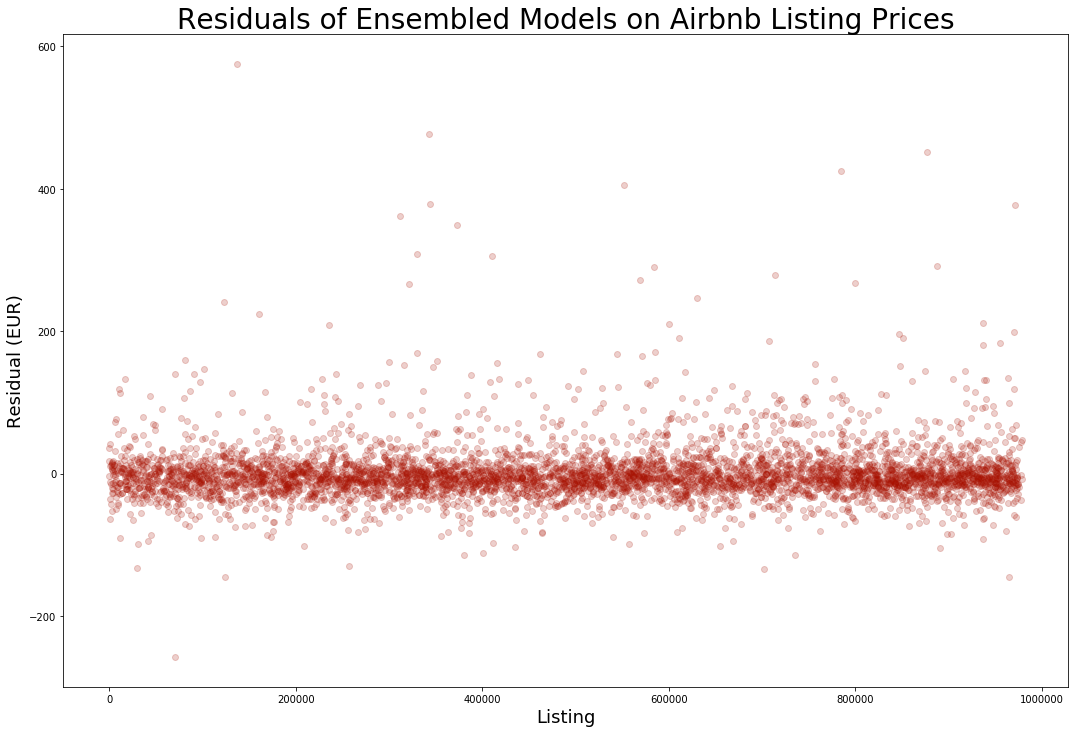

In [21]:
#  A plot of the prediction's residuals. It is mildly skew right, but it's normal enough to satisfy me. 
#  It's natural for the residual to skew a bit to the high side, I think, given the nature of prices
ax = plt.figure(figsize=(18,12))
plt.scatter(x=y_no_dupes.index, y=residuals, alpha=0.2, c='#A91101')
plt.xlabel('Listing', fontsize=18)
plt.ylabel('Residual (EUR)', fontsize=18)
plt.title('Residuals of Ensembled Models on Airbnb Listing Prices', fontsize=28);
# plt.savefig('/Users/HenryCarpenter/Desktop/GA_DS/berlin-airbnb-data/residual_plot.jpg')

In [31]:
#  displaying the mean, median, and standard deviation of the ensembled residuals
print('Mean of residuals:', abs(residuals).mean())
print('Median of residuals:', abs(residuals).median())
print('Standard deviation of residuals:', np.std((residuals)))

Mean of residuals: 23.611949197559877
Median of residuals: 14.793485743059634
Standard deviation of residuals: 40.19078349662395


In [30]:
#  displaying the mean, median, and standard deviation of the linear regressor residuals
print('Mean of residuals:', abs(residuals_lr).mean())
print('Median of residuals:', abs(residuals_lr).median())
print('Standard deviation of residuals:', np.std((residuals_lr)))

Mean of residuals: 24.481391346676197
Median of residuals: 15.782466025547137
Standard deviation of residuals: 41.05406582002281


In [29]:
#  displaying the mean, median, and standard deviation of the random forest regressor residuals
print('Mean of residuals:', abs(residuals_rfr).mean())
print('Median of residuals:', abs(residuals_rfr).median())
print('Standard deviation of residuals:', np.std((residuals_rfr)))

Mean of residuals: 24.707872429648795
Median of residuals: 15.880401397690676
Standard deviation of residuals: 41.11656004470703


In [32]:
print((abs(residuals) < 25).value_counts(normalize=True))
print((abs(residuals_rfr) < 25).value_counts(normalize=True))
print((abs(residuals_lr) < 25).value_counts(normalize=True))

True     0.704311
False    0.295689
Name: price, dtype: float64
True     0.688929
False    0.311071
Name: price, dtype: float64
True     0.676786
False    0.323214
Name: price, dtype: float64
